<a href="https://www.kaggle.com/code/geetmukherjee/markov-chain-regime-change?scriptVersionId=220718831" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/snp500-index/SnP.csv
/kaggle/input/btc-usd/BTC_USD Bitfinex Historical Data.csv


<h4>Step : 1</h4>

<h4>Team Member A</h4>

In [2]:
df = pd.read_csv('/kaggle/input/snp500-index/SnP.csv')

In [3]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
df['Returns'] = df['Price'].pct_change() * 100
columns = ['Open','High','Low','index']
df = df.drop(columns, axis=1)
df = df.dropna()
df.head()

,Price,Returns
Date,,
2022-12-29,3849.28,0.254721
2022-12-28,3783.22,-1.716165
2022-12-27,3829.25,1.216688
2022-12-23,3844.82,0.406607
2022-12-22,3822.39,-0.583382


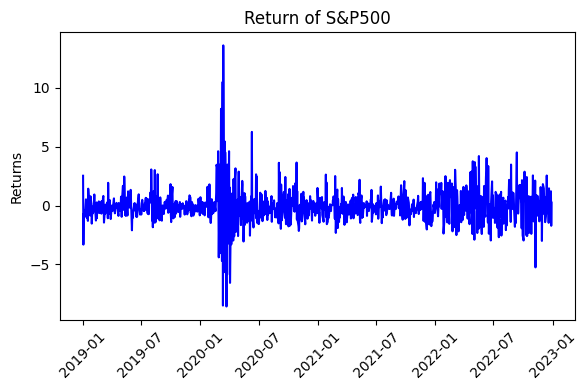

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df.index, df['Returns'], color='blue')
plt.title('Return of S&P500')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

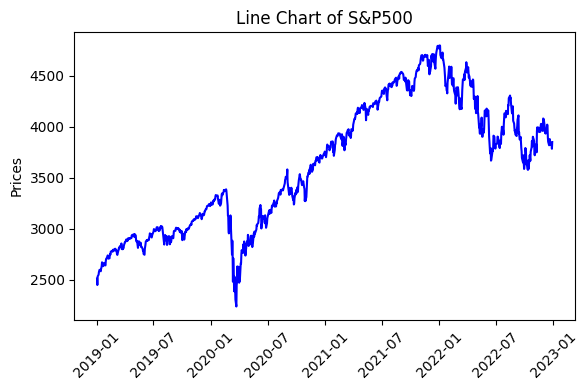

In [6]:
plt.figure(figsize=(6,4))
plt.plot(df.index, df['Price'], color='blue')
plt.title('Line Chart of S&P500')
plt.ylabel('Prices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Returns')

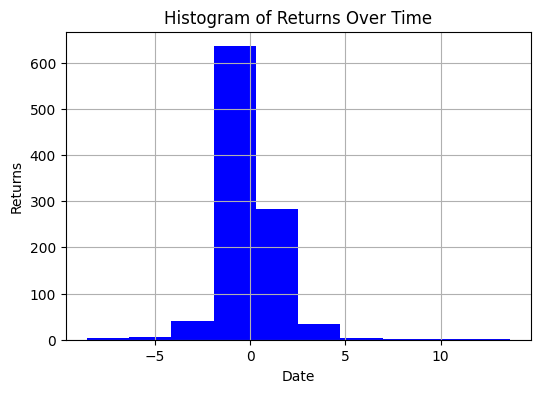

In [7]:
plt.figure(figsize=(6,4))
hist = df['Returns'].hist(bins=10, color='blue')
plt.title("Histogram of Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Returns")

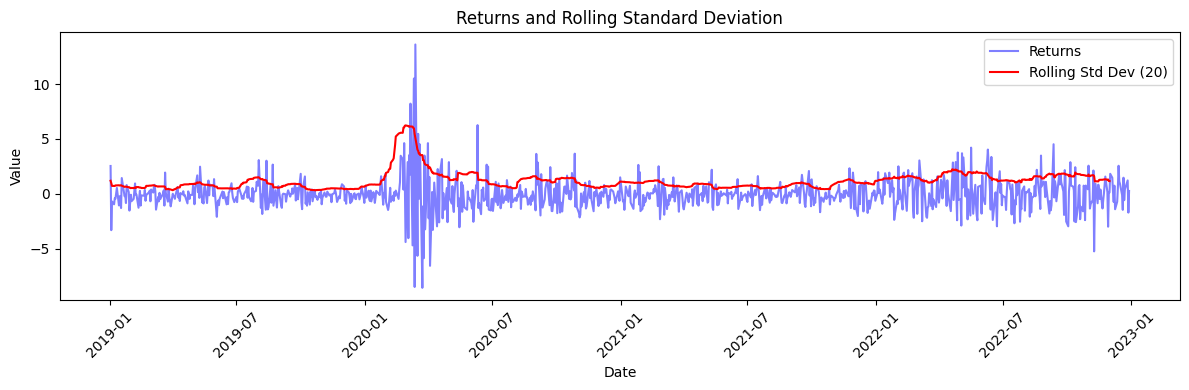

In [8]:
rolling_std = df['Returns'].rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Returns'], label="Returns", color='blue', alpha=0.5)
plt.plot(df.index, rolling_std, label="Rolling Std Dev (20)", color='red')
plt.title("Returns and Rolling Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Hamilton’s Markov Regime-Switching Model for univariate time series data.
import statsmodels.api as sm

data = df['Returns']
model = sm.tsa.MarkovRegression(data, k_regimes=3, trend='c', switching_variance=True)
fit = model.fit()
print(fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood               -1481.978
Date:                Tue, 04 Feb 2025   AIC                           2987.957
Time:                        07:04:18   BIC                           3046.934
Sample:                             0   HQIC                          3010.365
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1666      0.028     -5.888      0.000      -0.222      -0.111
sigma2         0.3182      0.030     10.629      0.0

<Axes: title={'center': 'Probability of being at Regime 0'}, xlabel='Date'>

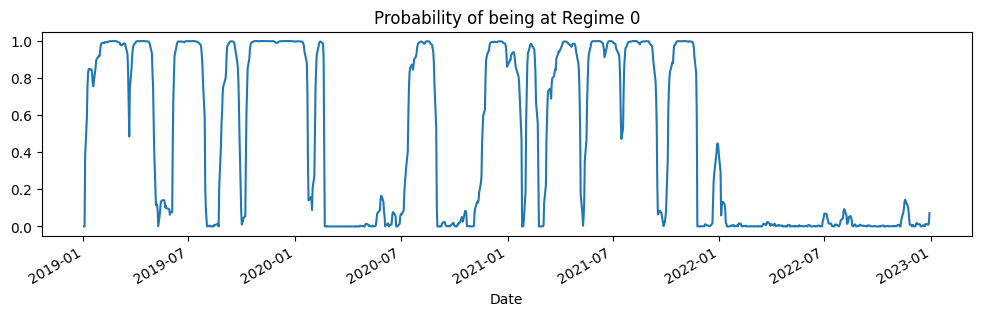

In [10]:
fit.smoothed_marginal_probabilities[0].plot(title="Probability of being at Regime 0", figsize=(12, 3))

<Axes: title={'center': 'Probability of being at Regime 1'}, xlabel='Date'>

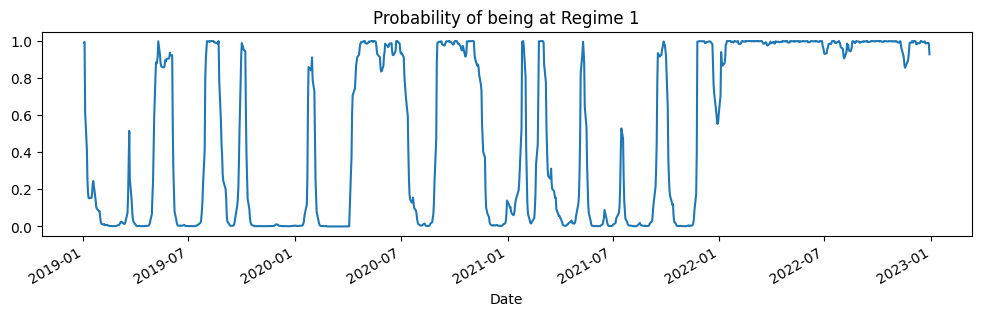

In [11]:
fit.smoothed_marginal_probabilities[1].plot(title="Probability of being at Regime 1", figsize=(12, 3)) 

<Axes: title={'center': 'Probability of being at Regime 2'}, xlabel='Date'>

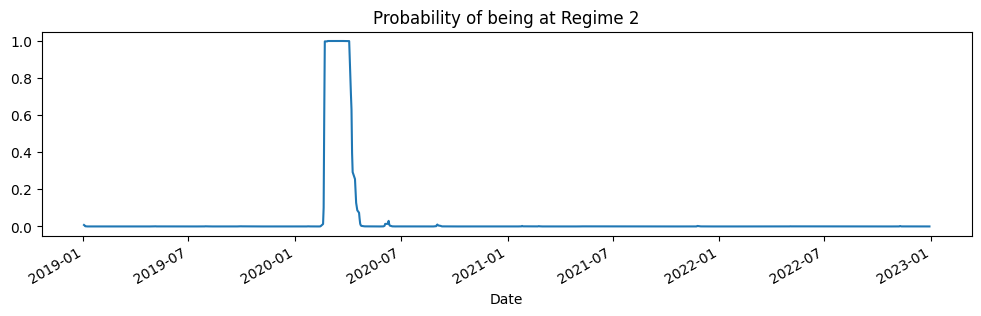

In [12]:
fit.smoothed_marginal_probabilities[2].plot(title="Probability of being at Regime 2", figsize=(12, 3))

In [13]:
predicted_regimes = fit.smoothed_marginal_probabilities[0]
predicted_regimes = np.argmax(fit.smoothed_marginal_probabilities, axis = 1)
df['regimes'] = predicted_regimes
df.head()

,Price,Returns,regimes
Date,,,
2022-12-29,3849.28,0.254721,1
2022-12-28,3783.22,-1.716165,1
2022-12-27,3829.25,1.216688,1
2022-12-23,3844.82,0.406607,1
2022-12-22,3822.39,-0.583382,1


In [14]:
datas = df.reset_index()
regime = datas.groupby('regimes').agg(start_date=('Date','first'),end_date=('Date','last'))

print(regime)

        start_date   end_date
regimes                      
0       2021-11-23 2019-01-07
1       2022-12-29 2019-01-02
2       2020-04-07 2020-02-20


<h4>Step 2: B. i. Different number of states.

In [15]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

def Markov_Reg_Regime(df):
    results= {}
    for i in range(2,5):  
        model_state = MarkovRegression(df['Returns'], k_regimes=i, trend='c', switching_variance=True)
        model_state_fit = model_state.fit()
        print(f"State Model {i} AIC: {model_state_fit.aic}, BIC: {model_state_fit.bic}")
        print(f"Model Parameters {i}: {model_state_fit.params}")
    return results


In [16]:
Markov_Reg_Regime(df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


State Model 2 AIC: 3141.82953727965, BIC: 3171.3179226359616
Model Parameters 2: p[0->0]      0.970800
p[1->0]      0.052386
const[0]    -0.141025
const[1]     0.171988
sigma2[0]    0.501309
sigma2[1]    5.093979
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


State Model 3 AIC: 2987.956909212916, BIC: 3046.933679925539
Model Parameters 3: p[0->0]      9.658793e-01
p[1->0]      2.793569e-02
p[2->0]      3.165191e-02
p[0->1]      3.412056e-02
p[1->1]      9.700418e-01
p[2->1]      4.718711e-07
const[0]    -1.665585e-01
const[1]     4.114467e-02
const[2]     7.221370e-01
sigma2[0]    3.181621e-01
sigma2[1]    2.138616e+00
sigma2[2]    2.535166e+01
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


State Model 4 AIC: 2974.549631278933, BIC: 3072.844249133304
Model Parameters 4: p[0->0]       0.954046
p[1->0]       0.000212
p[2->0]       0.040575
p[3->0]       0.016817
p[0->1]       0.045616
p[1->1]       0.117617
p[2->1]       0.044029
p[3->1]       0.002630
p[0->2]       0.000055
p[1->2]       0.880613
p[2->2]       0.914005
p[3->2]       0.007071
const[0]     -0.148502
const[1]     -1.245400
const[2]      0.144161
const[3]      0.610609
sigma2[0]     0.281920
sigma2[1]     0.078142
sigma2[2]     2.142353
sigma2[3]    25.036433
dtype: float64


{}

<h4>ii. Allowing the expected realization of the time series to differ across states
(different “mus”), but with constant variance (same “sigma”).</h4>

In [17]:
model_state_const_var = MarkovRegression(df['Returns'], k_regimes=3, trend='c', switching_variance=False, switching_trend=True)
model_state_const_var_fit = model_state_const_var.fit()

print(model_state_const_var_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood               -1809.210
Date:                Tue, 04 Feb 2025   AIC                           3638.421
Time:                        07:04:30   BIC                           3687.568
Sample:                             0   HQIC                          3657.094
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0210      1.573     -0.013      0.989      -3.103       3.061
                             Regime 1 parameters    

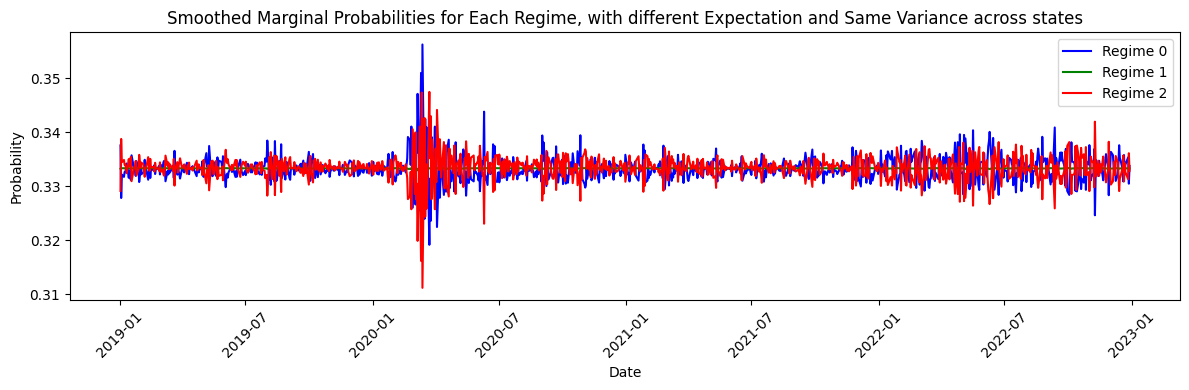

In [18]:
plt.figure(figsize=(12, 4))

plt.plot(df.index, model_state_const_var_fit.smoothed_marginal_probabilities[0], label="Regime 0", color='blue')
plt.plot(df.index, model_state_const_var_fit.smoothed_marginal_probabilities[1], label="Regime 1", color='green')
plt.plot(df.index, model_state_const_var_fit.smoothed_marginal_probabilities[2], label="Regime 2", color='red')

plt.title("Smoothed Marginal Probabilities for Each Regime, with different Expectation and Same Variance across states")
plt.xlabel("Date")
plt.ylabel("Probability")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<h4>III Allowing the variance of the time series to change across states (different
“sigmas”), but with constant expectation (same “mu”).</h4>

In [19]:
model_state_const_mean = MarkovRegression(df['Returns'], k_regimes=3, trend='c', switching_variance=True, switching_trend=False)
model_state_const_mean_fit = model_state_const_mean.fit()

print(model_state_const_mean_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood               -1486.456
Date:                Tue, 04 Feb 2025   AIC                           2992.913
Time:                        07:04:33   BIC                           3042.060
Sample:                             0   HQIC                          3011.586
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3219      0.034      9.607      0.000       0.256       0.388
                             Regime 1 parameters    

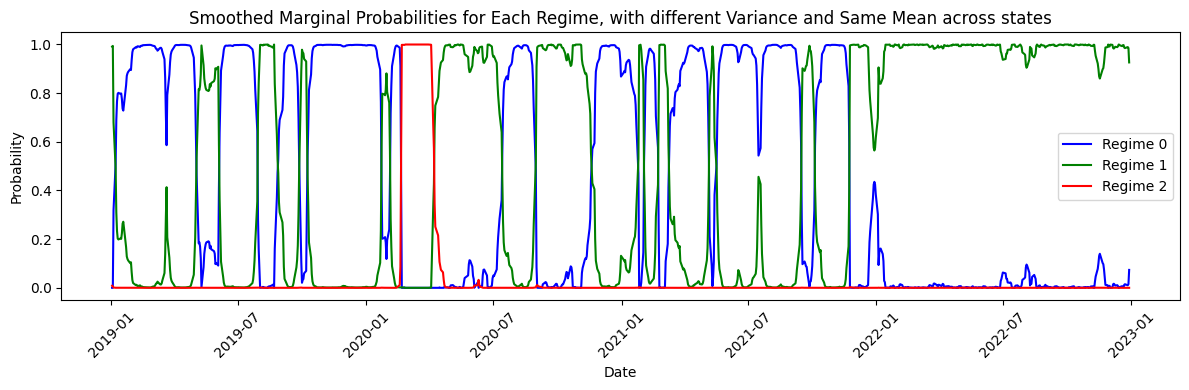

In [20]:
plt.figure(figsize=(12, 4))

plt.plot(df.index, model_state_const_mean_fit.smoothed_marginal_probabilities[0], label="Regime 0", color='blue')
plt.plot(df.index, model_state_const_mean_fit.smoothed_marginal_probabilities[1], label="Regime 1", color='green')
plt.plot(df.index, model_state_const_mean_fit.smoothed_marginal_probabilities[2], label="Regime 2", color='red')

plt.title("Smoothed Marginal Probabilities for Each Regime, with different Variance and Same Mean across states")
plt.xlabel("Date")
plt.ylabel("Probability")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<h4>IV Allowing for different expectations and variances across states.</h4>

In [21]:
model_state_diff = MarkovRegression(df['Returns'], k_regimes=3, trend='c', switching_variance=True, switching_trend=True)
model_state_diff_fit = model_state_diff.fit()

print(model_state_diff_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood               -1481.978
Date:                Tue, 04 Feb 2025   AIC                           2987.957
Time:                        07:04:36   BIC                           3046.934
Sample:                             0   HQIC                          3010.365
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1666      0.028     -5.888      0.000      -0.222      -0.111
sigma2         0.3182      0.030     10.629      0.0

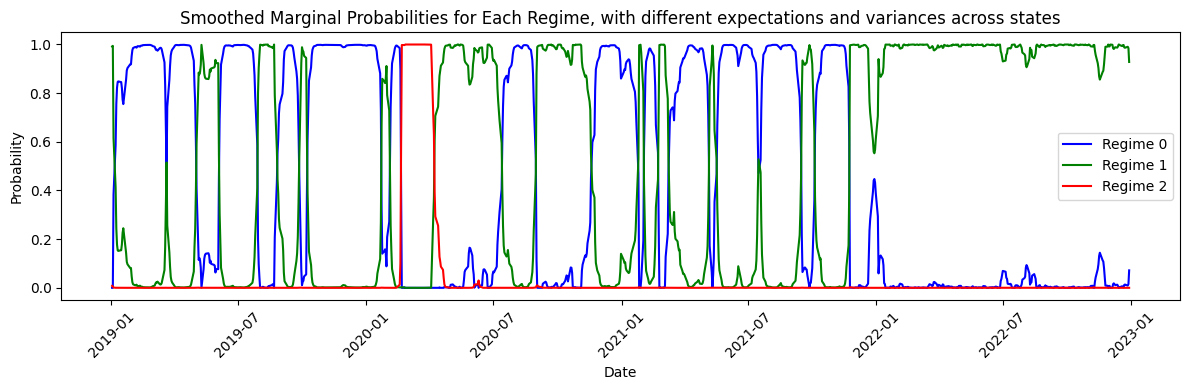

In [22]:
plt.figure(figsize=(12, 4))

plt.plot(df.index, model_state_diff_fit.smoothed_marginal_probabilities[0], label="Regime 0", color='blue')
plt.plot(df.index, model_state_diff_fit.smoothed_marginal_probabilities[1], label="Regime 1", color='green')
plt.plot(df.index, model_state_diff_fit.smoothed_marginal_probabilities[2], label="Regime 2", color='red')

plt.title("Smoothed Marginal Probabilities for Each Regime, with different expectations and variances across states")
plt.xlabel("Date")
plt.ylabel("Probability")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<h4>Step 3: comparing the models that had different mu values, that had different sigma values, that had different expectations and variances.</h4>

In [23]:
print('Model With Different Variance and Mean Value for each state')
print(f"AIC: {model_state_diff_fit.aic}")
print(f"BIC: {model_state_diff_fit.bic}")
print('')
print('Model With Different Variance and Constant Mean Value for each state')
print(f"AIC: {model_state_const_mean_fit.aic}")
print(f"BIC: {model_state_const_mean_fit.bic}")
print('')
print('Model With Constant Variance and Same Mean Value for each state')
print(f"AIC: {model_state_const_var_fit.aic}")
print(f"BIC: {model_state_const_var_fit.bic}")

Model With Different Variance and Mean Value for each state
AIC: 2987.956909212916
BIC: 3046.933679925539

Model With Different Variance and Constant Mean Value for each state
AIC: 2992.9127645944955
BIC: 3042.0600735216813

Model With Constant Variance and Same Mean Value for each state
AIC: 3638.4205966047984
BIC: 3687.5679055319843


<h4> Step 4 : estimating the models assuming that the time
series arises from an autoregressive process whose autoregressive coefficient changes
depending on the state, altogether with the variance of the perturbance term</h4>

In [24]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

model = MarkovAutoregression(df['Returns'], k_regimes=3, order=1, trend='c', switching_ar=True, switching_variance=True)
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                         Markov Switching Model Results                         
Dep. Variable:                  Returns   No. Observations:                 1006
Model:             MarkovAutoregression   Log Likelihood               -1475.461
Date:                  Tue, 04 Feb 2025   AIC                           2980.922
Time:                          07:04:41   BIC                           3054.628
Sample:                               0   HQIC                          3008.927
                                 - 1006                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1676      0.027     -6.225      0.000      -0.220      -0.115
sigma2         0.3163      0.030    

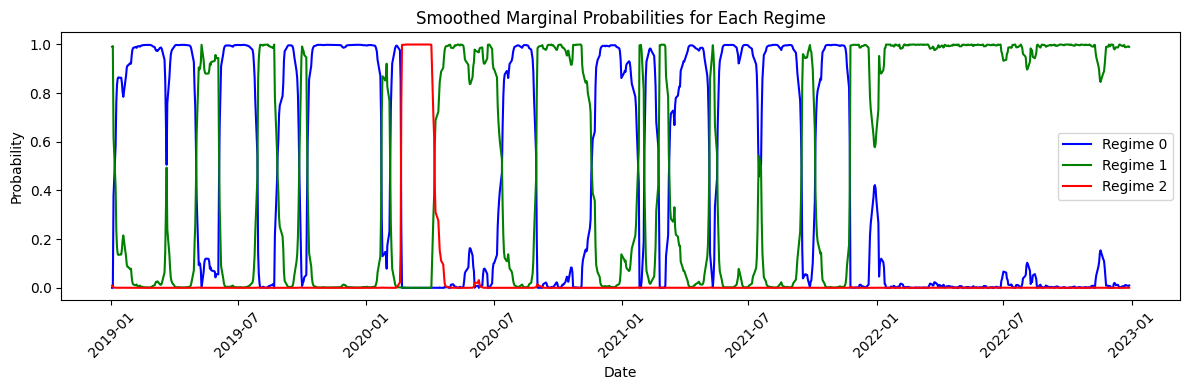

In [25]:
data = df.drop(df.index[0])

plt.figure(figsize=(12, 4))
plt.plot(data.index, result.smoothed_marginal_probabilities[0], label="Regime 0", color='blue')
plt.plot(data.index, result.smoothed_marginal_probabilities[1], label="Regime 1", color='green')
plt.plot(data.index, result.smoothed_marginal_probabilities[2], label="Regime 2", color='red')

plt.title("Smoothed Marginal Probabilities for Each Regime")
plt.xlabel("Date")
plt.ylabel("Probability")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
